# MTSSim from IDL to Python
This notebook is used to test the MTSSim (v2.6.1) port from IDL to python2.7.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Let's perform three tests for an MTS extended source observation. The blackbody source is set to 800K, 600K, and 400K respectively. This test setup is chosen in order to compare with the IDL output files that were used to perform the MRS spectrophotometric calibration.

In [1]:
from mtssim import MTSSim

# inputs
Usefilter = 'HOLE'
VASap = 100.
target = 'EXT'
MIRI='OFF'
pssON = None
parfile=None
instruct = {'OUTPATH':'/Users/ioannisa/Desktop/python/miri_devel/notebooks/pyMTSSim/OUTPUT/', # Path to the "outputs" folder.
            'SAVEEPS':False,                                                                  # Save graphs to .eps files? (yes/no).
            'EPSROOT':'Test',                                                                 # Root of the graphs' names.
            'SAVESPC':False,                                                                  # Save spectra to plain text file? (yes/no)
            'SPCFILE':'MTSSim_spec.fits',                                                     # Name of the file with the spectra.
            'SAVESUM':False,                                                                  # Save file with summary of results?
            'SPCSUMFILE':'Test_sim.fits',                                                     # Name of file with summary of results.
            'UNITS':'JY',                                                                     # Units of irradiance [MKS, CGS, PH, JY].
            'WMIN':2.,                                                                        # Minimum wavelength (>= 2 um)
            'WMAX':30.,                                                                       # Maximum wavelength (<=30 um)
            'DIVERGENCE':True,                                                                # Does the beam comming out of the BB diverge?
            'VASEMIT':True,                                                                   # Does the VAS emit? (yes/no)
            'CORRVAS':True}                                                                   # Account for difference between commanded and actual position of the VAS? (yes/no)
fluxes = None
plot = True

# run simulations
Vdata = {}
for BB_Temp in [800,600,400]:
    Vdata[str(BB_Temp)+'K'] = MTSSim(BB_Temp,Usefilter,VASap,target,MIRI=MIRI,parfile=parfile,instruct=instruct,fluxes=fluxes)

In [2]:
# load past simulations (used to derive the MRS spectrophotometric response)
from astropy.io import fits
MTSSim_SED = {}
for BB_Temp in ['800K','600K','400K']:
    MTSSim_fits = fits.open('/Users/ioannisa/Desktop/python/miri_devel/MRSFluxCal/MIRI_CDP6MRSFluxCal/Mts{}Jy.fits'.format(BB_Temp))
    MTSSim_SED[BB_Temp] = MTSSim_fits[1].data['SPC'][0]
MTSSim_wav = MTSSim_fits[1].data['WAVE'][0]

<IPython.core.display.Javascript object>


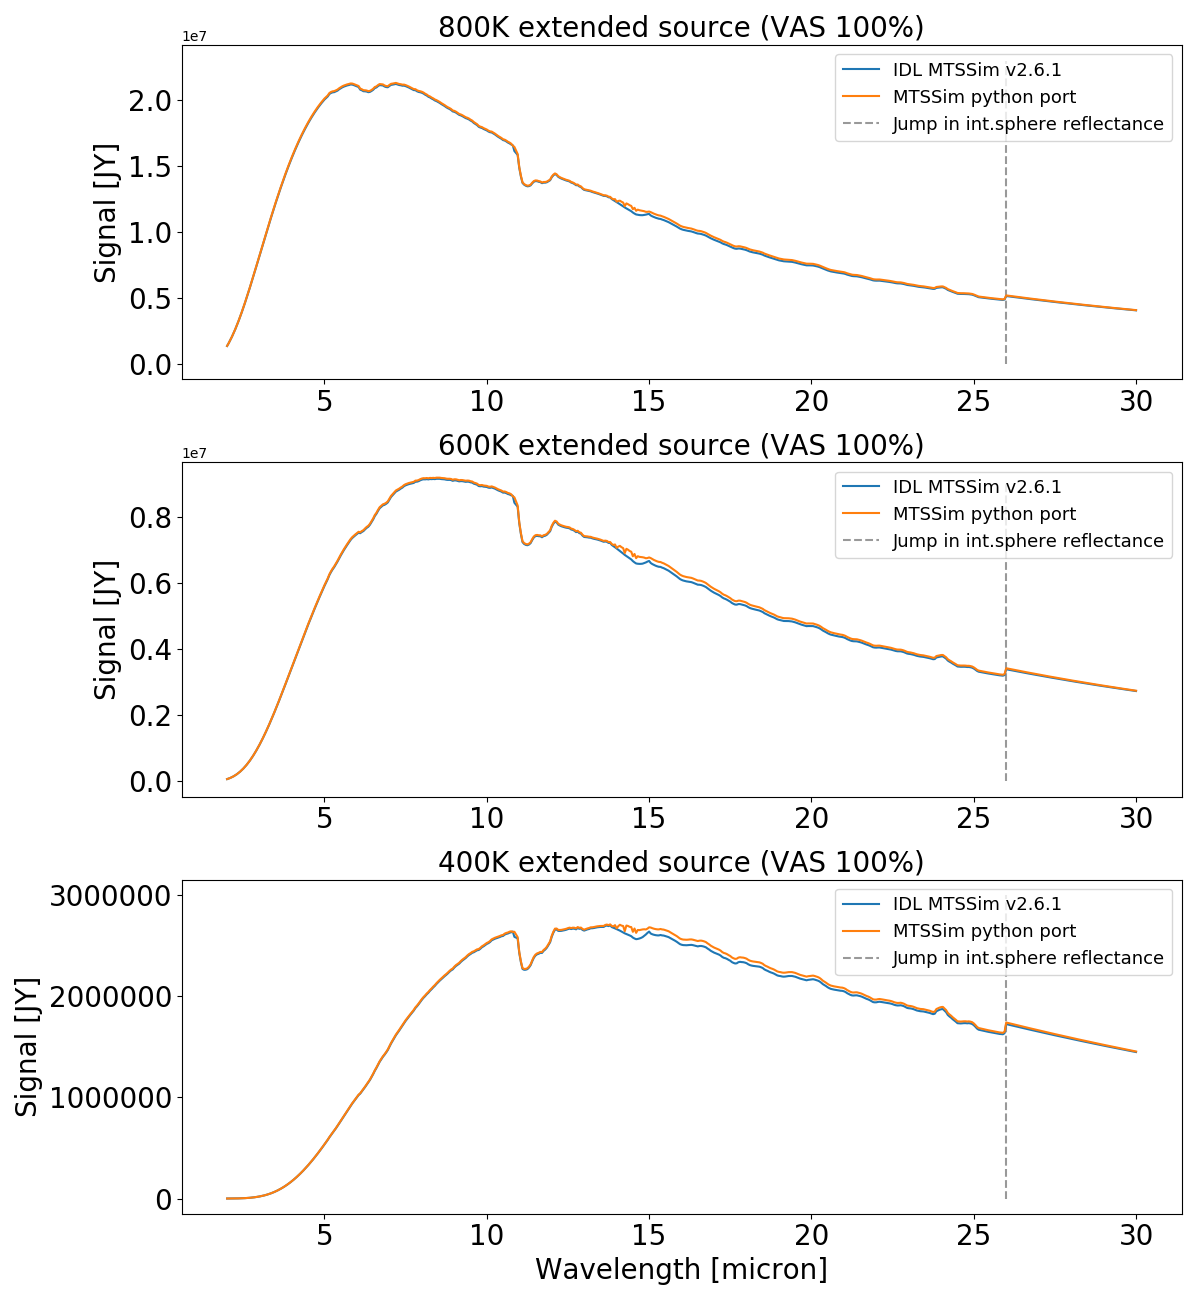

In [3]:
# make some comparative plots
import matplotlib.pyplot as plt
%matplotlib notebook

max_signal = [2.3E7,0.9E7,0.3E7]
fig,axs = plt.subplots(3,1,figsize=(12,13))
for plot,BB_Temp in enumerate(['800K','600K','400K']):
    axs[plot].set_title('{} extended source (VAS 100%)'.format(BB_Temp),fontsize=20)
    axs[plot].plot(MTSSim_wav,MTSSim_SED[BB_Temp],label='IDL MTSSim v2.6.1')
    axs[plot].plot(Vdata[BB_Temp]['wave'],Vdata[BB_Temp]['SPC'],label='MTSSim python port')
    axs[plot].vlines(26,0,max_signal[plot],linestyle='dashed',alpha=0.4,label='Jump in int.sphere reflectance')
    axs[plot].set_ylabel('Signal [{}]'.format(Vdata[BB_Temp]['units']),fontsize=20)
    axs[plot].legend(loc='upper right',fontsize=13)
    axs[plot].tick_params(axis='both',labelsize=20)
axs[2].set_xlabel('Wavelength [micron]',fontsize=20)
plt.tight_layout()

There appears to be a small difference between the python-ported output SED and the original IDL output SED. Let's plot the ratio of the two for the three test cases to see what is happening.

<IPython.core.display.Javascript object>


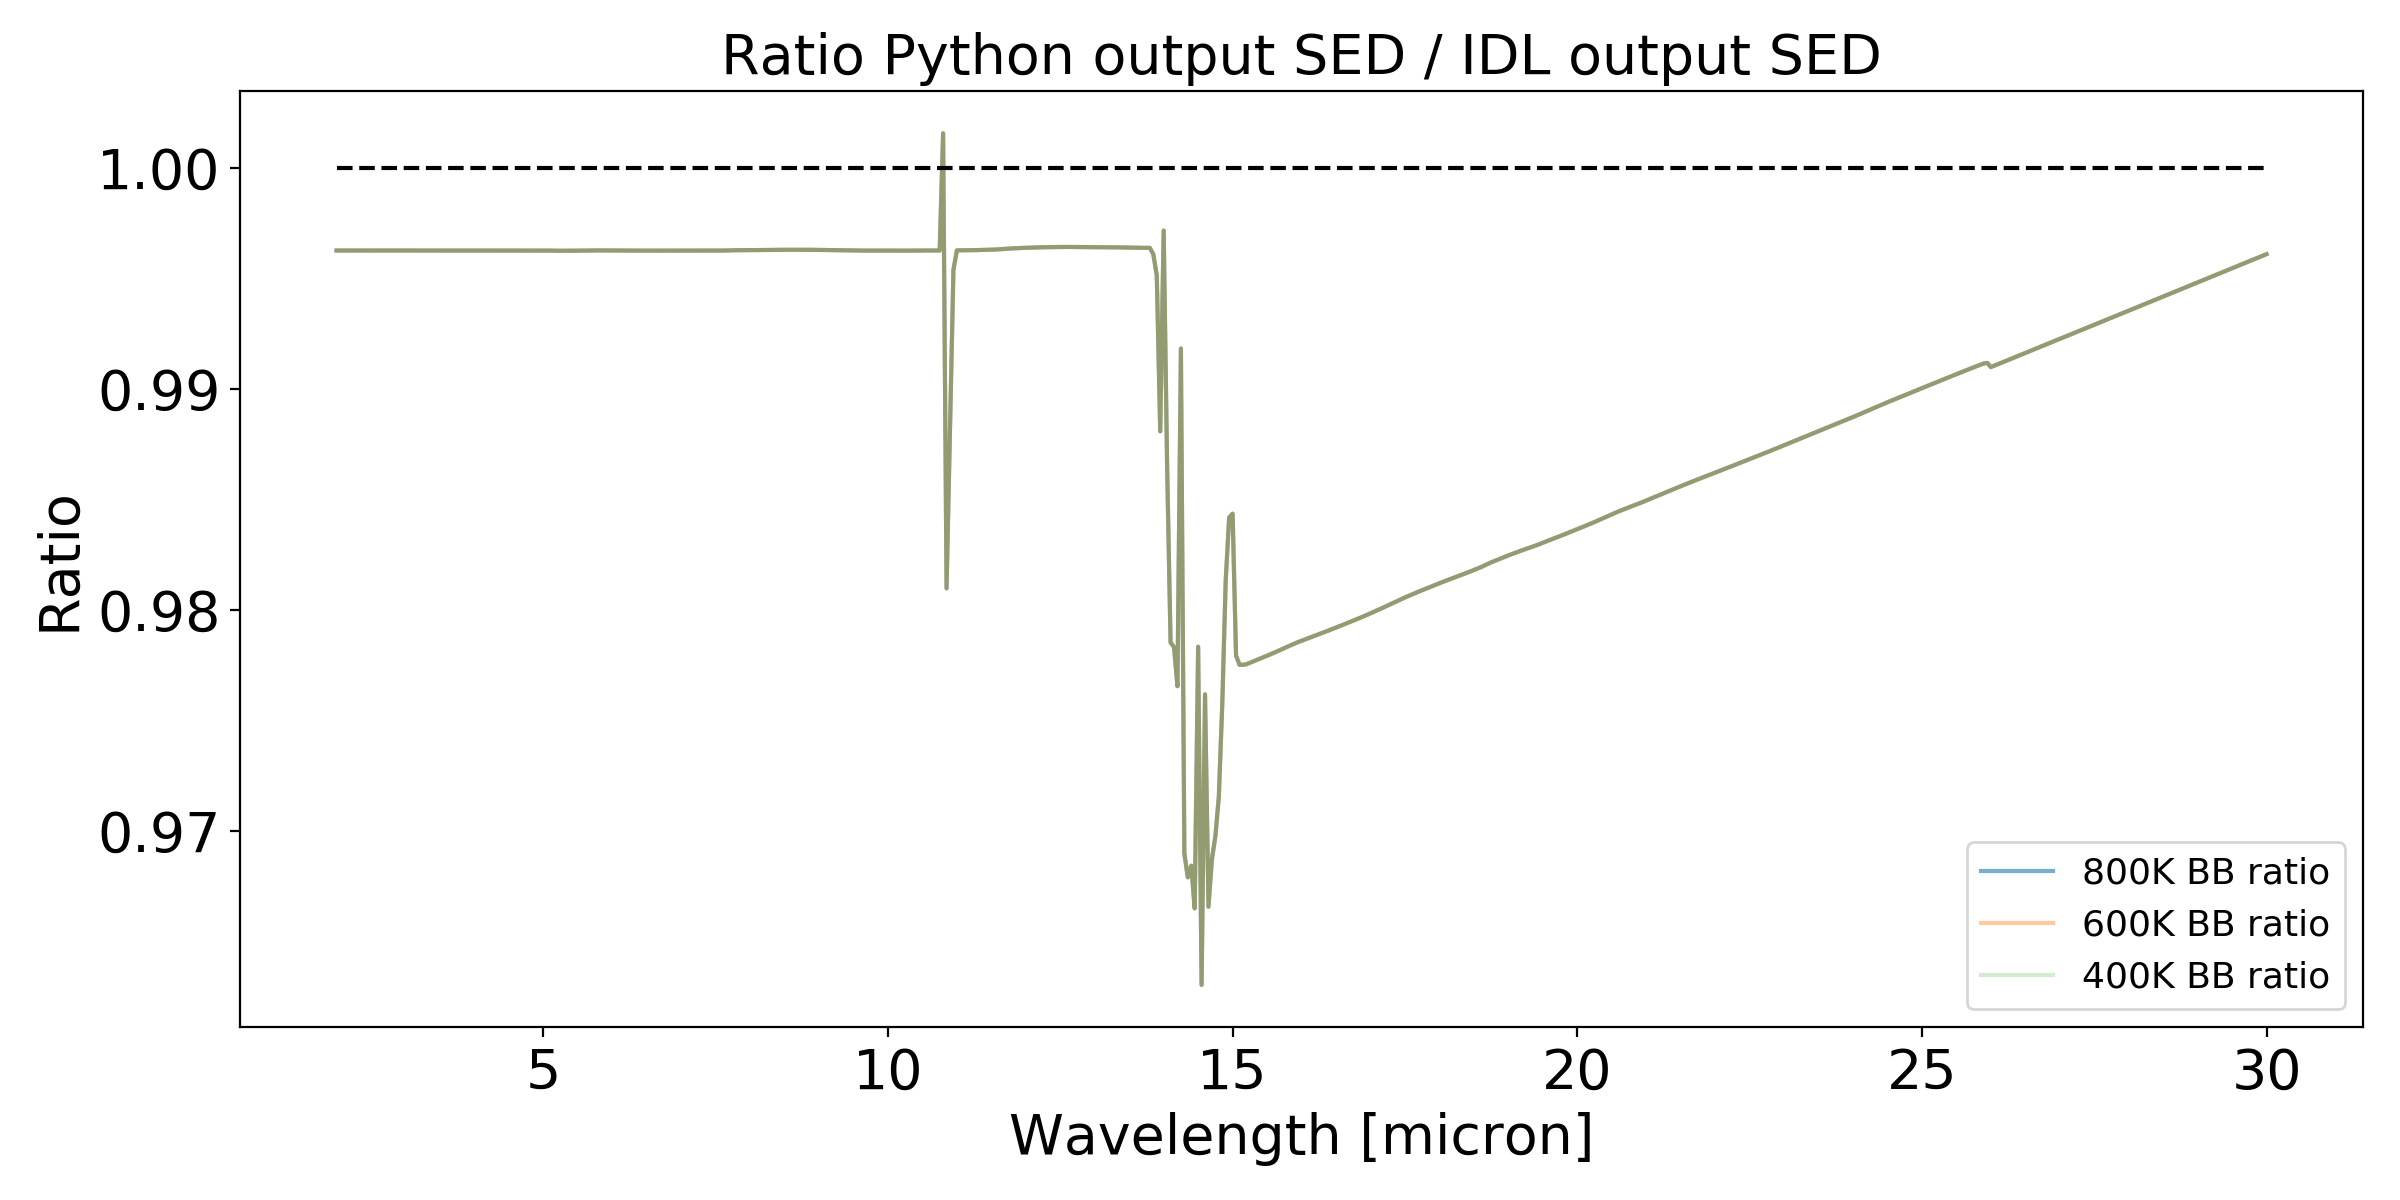

In [4]:
opacities = [0.6,0.4,0.2]
plt.figure(figsize=(12,6))
plt.title('Ratio Python output SED / IDL output SED',fontsize=20)
for plot,BB_Temp in enumerate(['800K','600K','400K']):
    plt.plot(Vdata[BB_Temp]['wave'],MTSSim_SED[BB_Temp]/Vdata[BB_Temp]['SPC'],alpha=opacities[plot],label='{} BB ratio'.format(BB_Temp),zorder=0)
plt.hlines(1,MTSSim_wav.min(),MTSSim_wav.max(),'k',linestyle='dashed',zorder=1)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Ratio',fontsize=20)
plt.legend(loc='lower right',fontsize=13)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

So,
* the ratio between the python-ported output SED and the IDL SED is the same for all three blackbody cases.
* The erratic-looking difference is actually caused by the handling (/interpolation) of the MTS MOS mirror transmission curve (stored in "MOStransmit.dat"). There is actually a discontinuity in the transmission data, which jump from 14.5 micron to 30 micron (i.e. there are no datapoints between these two edge wavelengths). The IDL/Python code handling of the discontinuity causes an initial deviation and subsequent slow convergence of the IDL output to the python-ported output.
* Given that a different transmission curve will be used from MTSSim v2.7 onwards ("MOScurve_capture_shift_blue0.06.txt" instead of "MOStransmit.dat", the former of which has a much better wavelength coverage), the above discrepancy between the IDL code and the python code is inconsequential.